In [8]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


In [27]:
!pip install pydicom
!pip install imgaug

In [2]:
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
from keras.utils import to_categorical
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
%pylab inline

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU') # gpus[번호바꿔서 사용 0-3번]
#tf.debugging.set_log_device_placement(True)

Populating the interactive namespace from numpy and matplotlib


In [5]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [6]:
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_dx = pd.read_csv(path + 'patient_meta.csv')
patient_dx = patient_dx[['RANDOM_PT_NO',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index)
patient_dx = patient_dx.drop(patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index, axis=0)
patient_dx.reset_index(drop=True, inplace=True)

def find_disease(patient_no):
    dx=np.array(patient_dx[patient_dx['RANDOM_PT_NO'] == patient_no]['DX'])[0]
    if 'metastasis'in dx:
        return 1
    elif dx == 'HCC':
        return 2
    elif dx == 'cholangiocarcinoma':
        return 3
    else:
        print(f"input error: wrong patient number {patient_no}")

Drop: Int64Index([42, 66, 69], dtype='int64')


In [7]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [8]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [9]:
# 1 patient 당 DX list 가져오기
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64)
n_ct_statistics=[]
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
# 1 patient 당 DX list 가져오기
grouped_df=label_df.groupby('patient_no').agg(list)

# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        X_i_tr_ct_list =  sorted(glob.glob(path+patient_no+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        
        # Load 3D CT Data per Patient
        label_block = np.zeros(shape=(n_ct)) # annotation label
        label_block[:] = find_disease(patient_no)
              
        ct_block = [] #사진
        for z in range(n_ct):
            #ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_tr_buffer = []
        Y_i_tr_buffer = []
        #DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            X_p_tr.append(patient_no)# patient number
            X_m_tr.append(patient_meta[tr_idx, 2:])   #meta 정보 전체
            maxVal = np.max(label_block[z:z+window_size])
            Y_i_tr_buffer.append(maxVal) #buffer에 annotation 겹쳐서 들어감
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        Y_i_tr_buffer = np.array(Y_i_tr_buffer)
        Y_tr.extend(Y_i_tr_buffer)
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        X_i_te_ct_list =  sorted(glob.glob(path+patient_no+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        label_block = np.zeros(shape=(n_ct)) # annotation label
        label_block[:] = find_disease(patient_no)
        
        ct_block = []
        for z in range(n_ct):
            #ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_te_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_te_ct_list[z]).pixel_array, dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        Y_i_te_buffer = []
        DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_no)
            X_m_te.append(patient_meta[te_idx, 2:])
            maxVal = np.max(label_block[z:z+window_size])
            Y_i_te_buffer.append(maxVal) #buffer에 annotation 겹쳐서 들어감
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
        Y_i_te_buffer = np.array(Y_i_te_buffer)
        Y_te.extend(Y_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    break

(10756,) (10756, 3) (10756, 5, 64, 64) (10756,)
(2651,) (2651, 3) (2651, 5, 64, 64) (2651,)


In [19]:
# Random split : Train : 70%
X_p = np.concatenate((X_p_tr, X_p_te), axis=0)
X_m = np.concatenate((X_m_tr, X_m_te), axis=0)
X_i = np.concatenate((X_i_tr, X_i_te), axis=0)
Y = np.concatenate((Y_tr, Y_te), axis=0)

from sklearn.model_selection import train_test_split

X_i_tr, X_i_te, Y_tr, Y_te = train_test_split(X_i,Y, test_size =0.3, random_state=42)
X_m_tr, X_m_te, Y_tr, Y_te = train_test_split(X_m,Y, test_size =0.3, random_state=42)
X_p_tr, X_p_te, Y_tr, Y_te = train_test_split(X_p,Y, test_size =0.3, random_state=42)

In [20]:
# CT Length Statistics
np.mean(n_ct_statistics)

138.07

In [21]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

0 6172 1992 1220
0 2659 842 522


In [23]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/'
path = './np_aug_2_nonROI/'
np.save(path+'X_p_tr_final', X_p_tr), np.save(path+'X_m_tr_final', X_m_tr), np.save(path+'X_i_tr_final', X_i_tr), np.save(path+'Y_tr_final', Y_tr)
np.save(path+'X_p_te_final', X_p_te), np.save(path+'X_m_te_final', X_m_te), np.save(path+'X_i_te_final', X_i_te), np.save(path+'Y_te_final', Y_te)

(None, None, None, None)

In [24]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(9384,) (9384, 3) (9384, 64, 64, 5) (9384,)
(4023,) (4023, 3) (4023, 64, 64, 5) (4023,)


### Augmentation 작업 전

In [35]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np_aug_2_nonROI/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final.npy'), np.load(path+'X_m_tr_final.npy', allow_pickle=True), np.load(path+'X_i_tr_final.npy'), np.load(path+'Y_tr_final.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final.npy'), np.load(path+'X_m_te_final.npy', allow_pickle=True), np.load(path+'X_i_te_final.npy'), np.load(path+'Y_te_final.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(9384,) (9384, 3) (9384, 64, 64, 5) (9384,) (9384, 4)
(4023,) (4023, 3) (4023, 64, 64, 5) (4023,) (4023, 4)


In [13]:
# # Permute Channels
# X_i_tr = np.rollaxis(X_i_tr, 1, 4)
# X_i_te = np.rollaxis(X_i_te, 1, 4)
# print(X_i_tr.shape)
# print(X_i_te.shape)

### Augmentation 작업 후

In [36]:
# Augmentations
import imgaug as ia
import imgaug.augmenters as iaa
n_aug = 2
window_size = 5
path = './np_aug_2_nonROI/'
for a in range(n_aug):
    seq_pipeline = iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Fliplr(0.5)),   # horizontally flip 50% of all image 
        iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), # 0-10% 비율로 높이와 너비를 잘라준다.
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.Sometimes(0.5, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},   # x,y축 모두 80-120% 크기변환
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x,y 축모두 -20 에서 +20으로 축변환
            rotate=(-25, 25),  # -25 에서 25 도 각도 변화
            shear=(-8, 8))), # -16에서 16 기울기 변화
        iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.5))) # 이미지의 대조를 악화시키거나 개선 시킨다.
        ## 추가해 볼 기법들
        # mixup
    ], random_order=True)
    X_i_tr_aug = np.copy(X_i_tr)
    for r in range(X_i_tr_aug.shape[0]):
        buffer_block = X_i_tr_aug[r]
        for z in range(window_size):
            buffer_block[z] = seq_pipeline(images=buffer_block[z])
        X_i_tr_aug[r] = buffer_block
    X_p_tr_aug, X_m_tr_aug, Y_tr_aug = np.copy(X_p_tr), np.copy(X_m_tr), np.copy(Y_tr)
    np.save(path+'X_p_tr_aug_%02d' %(a), X_p_tr_aug), np.save(path+'X_m_tr_aug_%02d' %(a), X_m_tr_aug), np.save(path+'X_i_tr_aug_%02d' %(a), X_i_tr_aug), np.save(path+'Y_tr_aug_%02d' %(a), Y_tr_aug)

In [37]:
# Load Augmented Dataset and concat with original train Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np_aug_2_nonROI/'
n_aug = 2
for a in range(n_aug):
    X_p_buffer, X_m_buffer, X_i_buffer, Y_tr_buffer = np.load(path+'X_p_tr_aug_%02d.npy' %(a)), np.load(path+'X_m_tr_aug_%02d.npy' %(a), allow_pickle=True).astype('float32'), np.load(path+'X_i_tr_aug_%02d.npy' %(a)), np.load(path+'Y_tr_aug_%02d.npy' %(a))
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.concatenate((X_p_tr, X_p_buffer), axis=0), np.concatenate((X_m_tr, X_m_buffer), axis=0), np.concatenate((X_i_tr, X_i_buffer), axis=0), np.concatenate((Y_tr, Y_tr_buffer), axis=0)
Y_tr_cat = to_categorical(Y_tr)
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(28152,) (28152, 3) (28152, 64, 64, 5) (28152,) (28152, 4)
(4023,) (4023, 3) (4023, 64, 64, 5) (4023,) (4023, 4)


### Save augmented Dataset 
- 여기서 부터 실행

In [38]:
# Save Dataset
path = './np_aug_2_nonROI/'
np.save(path+'X_p_tr_final', X_p_tr), np.save(path+'X_m_tr_final', X_m_tr), np.save(path+'X_i_tr_final', X_i_tr), np.save(path+'Y_tr_final', Y_tr)
np.save(path+'X_p_te_final', X_p_te), np.save(path+'X_m_te_final', X_m_te), np.save(path+'X_i_te_final', X_i_te), np.save(path+'Y_te_final', Y_te)

(None, None, None, None)

### Load final Dataset

In [3]:
# Load Dataset
path = './np_aug_2_nonROI/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final.npy'), np.load(path+'X_m_tr_final.npy', allow_pickle=True), np.load(path+'X_i_tr_final.npy'), np.load(path+'Y_tr_final.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final.npy'), np.load(path+'X_m_te_final.npy', allow_pickle=True), np.load(path+'X_i_te_final.npy'), np.load(path+'Y_te_final.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(28152,) (28152, 3) (28152, 64, 64, 5) (28152,) (28152, 4)
(4023,) (4023, 3) (4023, 64, 64, 5) (4023,) (4023, 4)


In [4]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

0 18516 5976 3660
0 2659 842 522


In [43]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(28152, 64, 64, 5)
(4023, 64, 64, 5)


In [53]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)


# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()

#cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
# cnn = tf.keras.Model(cnn_input, cnn_output)
# cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# cnn.summary()

#display(Image(filename="./Kyoung/Image/cnn.png"))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 64, 64, 5, 1) 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_15 (Conv3D)              (None, 64, 64, 5, 16 144         reshape_4[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_15 (MaxPooling3D) (None, 32, 32, 5, 16 0           conv3d_15[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])

Epoch 1/200
939/939 - 11s - loss: 0.0530 - accuracy: 0.9861 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 2/200
939/939 - 11s - loss: 3.0541e-04 - accuracy: 1.0000 - val_loss: 6.8718e-04 - val_accuracy: 1.0000
Epoch 3/200
939/939 - 11s - loss: 1.1240e-04 - accuracy: 1.0000 - val_loss: 4.0729e-04 - val_accuracy: 1.0000
Epoch 4/200
939/939 - 11s - loss: 6.0041e-05 - accuracy: 1.0000 - val_loss: 3.3717e-04 - val_accuracy: 1.0000
Epoch 5/200
939/939 - 11s - loss: 3.5300e-05 - accuracy: 1.0000 - val_loss: 2.5395e-04 - val_accuracy: 1.0000
Epoch 6/200
939/939 - 11s - loss: 2.1361e-05 - accuracy: 1.0000 - val_loss: 2.4209e-04 - val_accuracy: 1.0000
Epoch 7/200


In [46]:
cnn.evaluate(X_i_te,Y_te_cat)

126/126 [==============================] - 1s 6ms/step - loss: 7.9909e-04 - accuracy: 0.9998


[0.0007990876911208034, 0.9997514486312866]

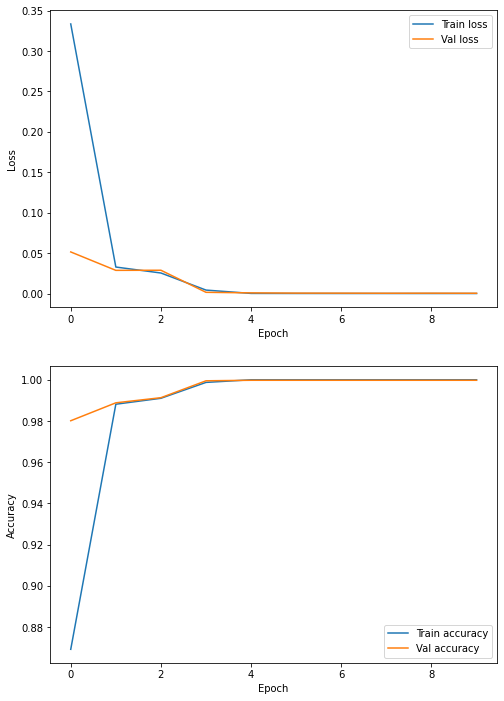

In [47]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [5]:
# save model
#cnn.save("./models/Dilated_3D_cnn_meta_aug.h5")

# model load하는 경우
cnn  = tf.keras.models.load_model("./models/Dilated_3D_cnn_meta_aug.h5")

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [9]:
def output_class(x):
    output = np.argmax(x)
    #if output == 0:
    #    return 'non-ROI'
    if output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [10]:
y_pred = cnn.predict(X_i_tr)
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
pd.DataFrame(confusion_matrix(y_true, y_pred_classified),columns=sorted(['metastasis','HCC','cholangiocarcinoma']),index=sorted(['metastasis','HCC','cholangiocarcinoma']))

,HCC,cholangiocarcinoma,metastasis
HCC,5976,0,0
cholangiocarcinoma,0,3660,0
metastasis,0,0,18516


In [51]:
# X_train을 통한 예측값 비교
y_pred = cnn.predict(X_i_tr)
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 5976     0     0]
 [    0  3660     0]
 [    0     0 18516]]
                    precision    recall  f1-score   support

               HCC       1.00      1.00      1.00      5976
cholangiocarcinoma       1.00      1.00      1.00      3660
        metastasis       1.00      1.00      1.00     18516

          accuracy                           1.00     28152
         macro avg       1.00      1.00      1.00     28152
      weighted avg       1.00      1.00      1.00     28152



In [11]:
y_pred = cnn.predict(X_i_te)
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
pd.DataFrame(confusion_matrix(y_true, y_pred_classified),columns=sorted(['metastasis','HCC','cholangiocarcinoma']),index=sorted(['metastasis','HCC','cholangiocarcinoma']))

,HCC,cholangiocarcinoma,metastasis
HCC,841,0,1
cholangiocarcinoma,0,522,0
metastasis,0,0,2659


In [52]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn.predict(X_i_te)     
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 841    0    1]
 [   0  522    0]
 [   0    0 2659]]
                    precision    recall  f1-score   support

               HCC       1.00      1.00      1.00       842
cholangiocarcinoma       1.00      1.00      1.00       522
        metastasis       1.00      1.00      1.00      2659

          accuracy                           1.00      4023
         macro avg       1.00      1.00      1.00      4023
      weighted avg       1.00      1.00      1.00      4023

